Seattle 2014 Incidents Summary

This analysis includes:
- Distribution of incidents during the day (time-of-day)
- Number of incidents per hour
- Correlation between selected incident types
- Spatial distribution of incidents (for the given day of year)

In [2]:
import datetime
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.style.use('ggplot')
%matplotlib inline

In [3]:
### Loading and preparing data 

## Frequently used column names

# start-end dates are used to calculate Hour, DayOfYear and TimeOfDay columns
start_date_col = 'Occurred Date or Date Range Start'
end_date_col = 'Occurred Date Range End'
# this column represents the incident type
incident_col = 'Summarized Offense Description'
# this column is used for counting unique incidents of the given type
id_col = 'RMS CDW ID'
# this is the calculated column representing total number of incidents per day
total_col = 'Total incidents per day'

## Calculating Hour, DayOfYear and TimeOfDay columns

def time_of_day(h):
    day_map = {
        '1_morning': range(5, 13), 
        '2_afternoon': range(12, 18), 
        '3_evening': range(17, 22), 
        '4_night': range(21, 24) + range(0, 6)        
    }
        
    if h < 0 or h >= 24: raise Exception('Hour must be in 0-23 range.')
    
    return [key for key, value in day_map.iteritems() if h in value][0]

df_all = pd.read_csv('seattle_incidents_summer_2014.csv', low_memory=False)
df_all['Hour'] = pd.DatetimeIndex(df_all[start_date_col]).hour
df_all['DayOfYear'] = pd.DatetimeIndex(df_all[start_date_col]).dayofyear
df_all['TimeOfDay'] = df_all.apply(lambda r: time_of_day(r['Hour']) , axis=1)

## Filtering original dataframe to only used columns. Excluding false reports.

df = df_all[[
    id_col, 
    incident_col,
    start_date_col,end_date_col, 
    'Month','Year', 'Hour', 'DayOfYear', 'TimeOfDay']][df_all[incident_col] != 'FALSE REPORT']

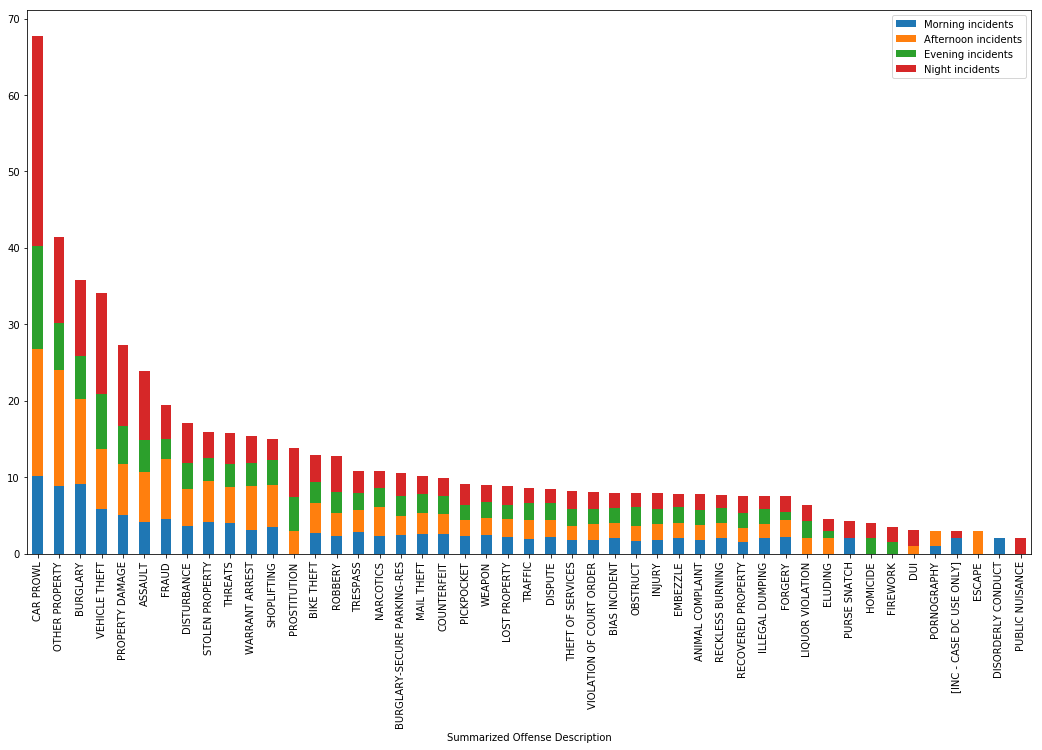

In [4]:
### Distribution of incidents during the day (time-of-day)

## Approach: 

# Data: transform and aggregate to get a dataframe with:
# - one row for incident type 
# - one column for each time-of-day (showing number of incidents of that type) 
# Visualization: stacked bar chart to identify
# - most frequent incident types during a typical day 
# - time-of-day distribution for each incident type 
# - potential correlation between incident types

## Steps:

# Filter data for each of time-of-day values (like 'morning', 'afternoon'...) 
# Group by day of year to see how many incidents of given type happened on each day 
# Group by incident type to get daily mean for that type

# Takes filtered data for the given TimeOfDay and do groupings and aggregations
def bar_plot_group(df_in, series_name):     
    df_out = df_in.groupby(['Year', 'DayOfYear', incident_col], as_index=False)[id_col].count()
    df_out = df_out.groupby([incident_col], as_index=False).mean()[[incident_col, id_col]]
    # This renams id_col ('RMS CDW ID') to a name indicating time-of-day 
    df_out.columns = [incident_col, series_name]    
    
    return df_out  

# For each TimeOfDay value filter data and call bar_plot_group to get daily means for each incident type 
dft1 = bar_plot_group(df[df['TimeOfDay']=='1_morning'], 'Morning incidents') 
dft2 = bar_plot_group(df[df['TimeOfDay']=='2_afternoon'], 'Afternoon incidents') 
dft3 = bar_plot_group(df[df['TimeOfDay']=='3_evening'], 'Evening incidents') 
dft4 = bar_plot_group(df[df['TimeOfDay']=='4_night'], 'Night incidents') 

# Merge into a single dataframe where each time-of-day has one column showing the number of incidents
dft = pd.merge(dft1, dft2, how='outer', on=[incident_col], sort=False)
dft = pd.merge(dft , dft3, how='outer', on=[incident_col], sort=False)
dft = pd.merge(dft , dft4, how='outer', on=[incident_col], sort=False)

dft = dft.fillna(0)

# Calculate total number of incidents for given incident type in order to sort
dft['Total'] = dft['Morning incidents'] + dft['Afternoon incidents'] + dft['Evening incidents'] + dft['Night incidents']
dft = dft.sort_values(by=['Total'], ascending=[0])
del dft['Total']

dft.plot(x=incident_col, figsize=(18,10), kind='bar', stacked=True)

Insights:
- CAR PROWL is the dominant incident type for each of time-of-day intervals
- Similar of time-of-day distributions indicates potential correlation between CAR PROWL and VEHICLE THEFT incident types


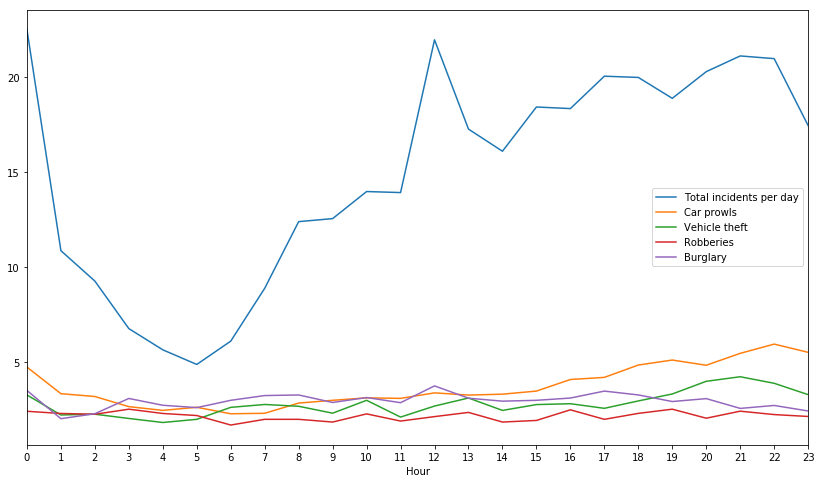

In [5]:
### Number of incidents per hour

## Approach: 

# Data: transform and aggregate to get a dataframe with:
# - one row for each hour of a day
# - one column for each of the selected incident types, and one for the total number of incidents for that hour  
# Visualization: line chart to show
# - daily pattern on incident counts
# - potential correlation between selected incident types 

## Steps:

# Filter data for each of the selected incident types 
# Group by hour of each day of year 
# Group by hour (rows) to get hourly mean for each of selected incident types (columns)


def line_plot_group_by_hour(df_in, group_col, series_name):    
    df_out = df_in[['Year', 'DayOfYear',group_col, id_col]]    
    df_out = df_out.groupby(['Year', 'DayOfYear',group_col], as_index=False).count()                 
    df_out = df_out.groupby([group_col], as_index=False).mean()[[group_col, id_col]]
    df_out.columns = [group_col, series_name]
    
    return df_out

dfh1 = line_plot_group_by_hour(df, 'Hour', total_col)
dfh2 = line_plot_group_by_hour(df[df[incident_col] == 'CAR PROWL'], 'Hour', 'Car prowls')
dfh3 = line_plot_group_by_hour(df[df[incident_col] == 'VEHICLE THEFT'], 'Hour', 'Vehicle theft')
dfh4 = line_plot_group_by_hour(df[df[incident_col] == 'ROBBERY'], 'Hour', 'Robberies')
dfh5 = line_plot_group_by_hour(df[df[incident_col] == 'BURGLARY'], 'Hour', 'Burglary')

dfh = pd.merge(dfh1, dfh2, how='outer')
dfh = pd.merge(dfh , dfh3, how='outer')
dfh = pd.merge(dfh , dfh4, how='outer')
dfh = pd.merge(dfh , dfh5, how='outer')

dfh.plot(figsize=(14,8), x='Hour', xticks = dfh.index)

Insights:
- Early morning has the lowest number of incidents
- Number of incidents starts to rais with the commute starts
- Evening has the highest number of incidents
- There is a correlation between CAR PROWL and VEHICLE THEFT incident types 


               Car prowls  Vehicle theft  Robberies  Burglary
Car prowls       1.000000       0.801812   0.374188 -0.065140
Vehicle theft    0.801812       1.000000   0.222794  0.103675
Robberies        0.374188       0.222794   1.000000 -0.103923
Burglary        -0.065140       0.103675  -0.103923  1.000000


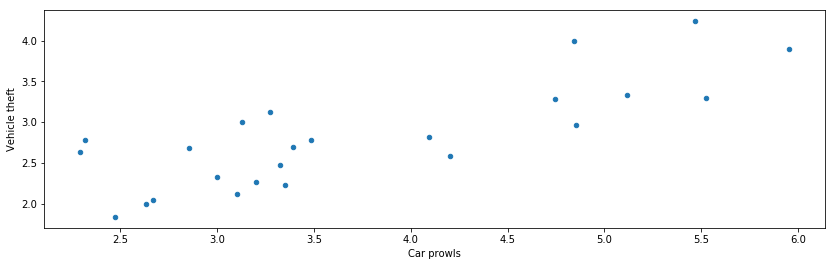

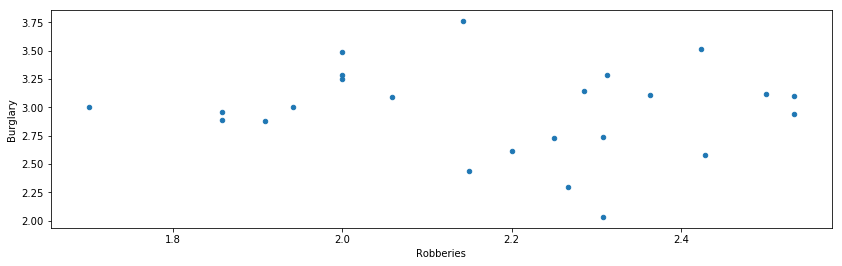

In [15]:
### Correlation between selected incident types

dfc = dfh[['Car prowls', 'Vehicle theft', 'Robberies', 'Burglary']]
print dfc.corr()
dfc.plot(figsize=(14,4), kind='scatter', x='Car prowls', y='Vehicle theft')
dfc.plot(figsize=(14,4), kind='scatter', x='Robberies', y='Burglary')
plt.show()

Insights:
- CAR PROWL and VEHICLE THEFT incident types have positive correlation of ~0.8


In [7]:
### Spatial distribution of incidents (for the given day of year)

## Approach: 

# Data: extract spatial information (lat/lon) 
# Visualization: use 'folium' to show clustered incident data on a map

## Steps:

# - filter data to the randomly selected day 200 ('folium' performance consideration)
# - exclude data without lat/lon info
# - store lat/lon data in the list of tuples 
# - use 'folium' objects to visualize data on the map 


import numpy as np
import folium
from folium.plugins import MarkerCluster
from ast import literal_eval as make_tuple

dff = df_all[df_all['DayOfYear']==200]

dfll = dff[(dff.Longitude !=0) & (dff.Latitude !=0)]
latlon = [make_tuple(v[0]) for v in dfll[['Location']].values]

#center = map(np.mean, zip(*latlon))
m = folium.Map( location=[47.600571, -122.321648], zoom_start=11, tiles='cartodbpositron' )
import random
m.add_child(MarkerCluster(locations=latlon))

## NOTE: When hosted in GitHub the map will not show. If so, please see the attached snapshot below.

![Seattle_2014_day_200_incidents.PNG](Seattle_2014_day_200_incidents.PNG)

Insights:
- The number of incidents is higher in the downtown area 